# Design

*   **Business Type** - game console
*   **Business Objective** - แนะนำเกมส์ที่ใกล้เคียงกับสิ่งที่ลูกค้าค้นหา
*   **Learning Problems** - Item similarity
*   **The reason I choose this project** - เราต้องการจะแนะนำเกมส์ที่มีความใกล้เคียงกับสิ่งที่ลูกค้าหา
*   **The expected results would be** - Game Name, Developer, Publisher, Genres
*   **How I use the result** - เอาไปแสดงแนะนำเกมส์ที่ใกล้เคียงกับที่ลูกค้าค้นหาให้ลูกค้าได้ดู
*   **The benefits of this project** - ทำให้ลูกค้าสนใจที่จะซื้อเกมส์อื่นมากขึ้นกระตุ้นยอดขายได้ดีมากยิ่งขึ้น

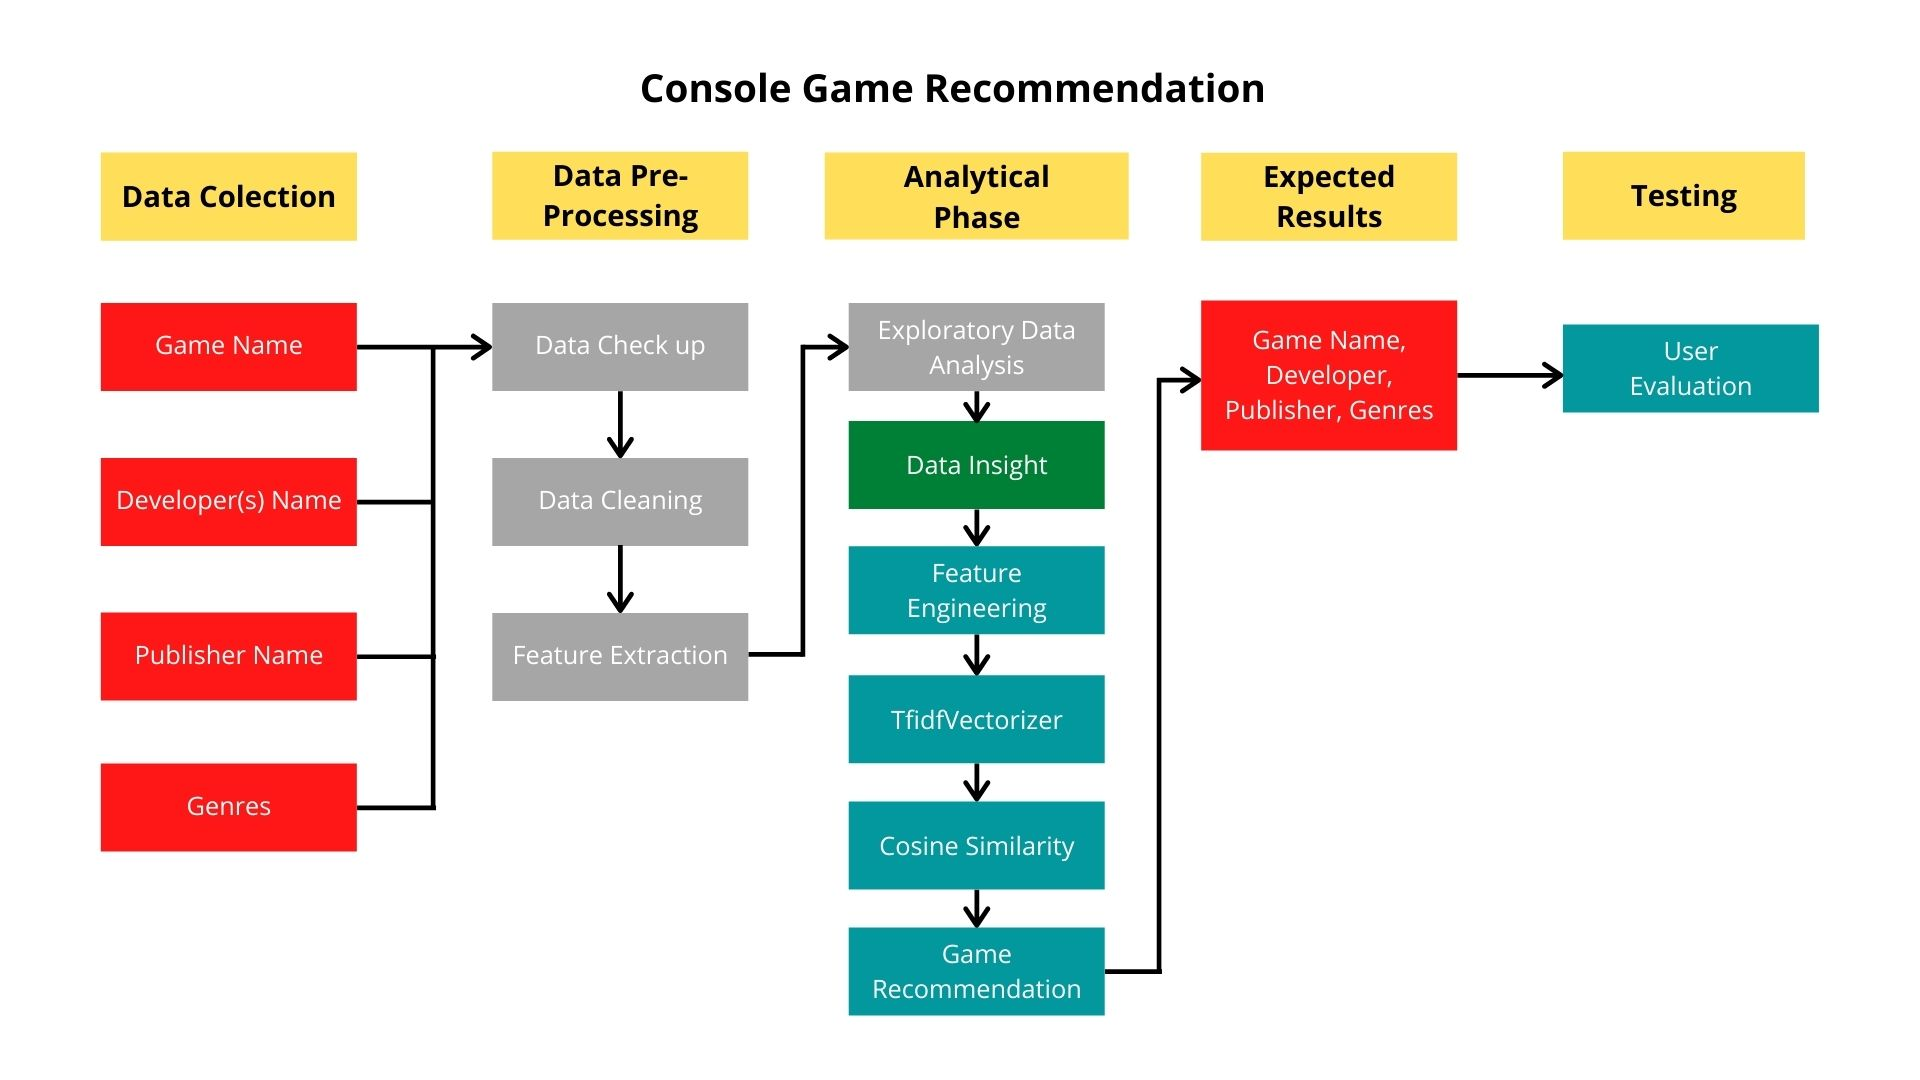

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

import time

!pip install gradio -q
import gradio as gr

     |████████████████████████████████| 979 kB 6.6 MB/s 
     |████████████████████████████████| 2.0 MB 50.0 MB/s 
     |████████████████████████████████| 206 kB 42.2 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 3.6 MB 44.0 MB/s 
     |████████████████████████████████| 961 kB 65.8 MB/s 


# **Importing Dataset**

In [ ]:
file_name = "https://raw.githubusercontent.com/wtamu-cisresearch/scraper/master/gamedata-20140215-11_53_10.csv"
#pd.set_option('display.max_rows', None)
pd.reset_option('^display.', silent=True)
video_game_data = pd.read_csv(file_name, encoding="utf-8")
video_game_data.head(5)

,,,,,,,,,,,,,,,,DateTime:,2014-02-15 11:53:10.492000
name,platform,release year,genre,publisher,north america sales,europe sales,japan sales,rest of world sales,global sales,release date,critic score,critic outof,critic count,user score,user count,developer,rating
Wii Sports,Wii,2006,Sports,Nintendo,41.02,28.66,3.77,8.39,81.84,"Nov 19, 2006",76,100,51,8.2,229,Nintendo,E
Mario Kart Wii,Wii,2008,Racing,Nintendo,15.07,12.36,3.71,3.19,34.33,"Apr 27, 2008",82,100,73,8.2,503,Nintendo,E
Wii Sports Resort,Wii,2009,Sports,Nintendo,15.38,10.71,3.25,2.89,32.24,"Jul 26, 2009",80,100,73,7.7,132,Nintendo,E
Wii Play,Wii,2006,Misc,Nintendo,13.89,9.14,2.93,2.83,28.79,"Feb 12, 2007",58,100,41,6.5,103,Nintendo,E


In [ ]:
video_game_data = pd.read_csv(file_name, header=1, encoding="utf-8")
video_game_data.sample(5)

,name,platform,release year,genre,publisher,north america sales,europe sales,japan sales,rest of world sales,global sales,release date,critic score,critic outof,critic count,user score,user count,developer,rating
3392,Invizimals: The Lost Tribes,PSP,2011.0,Action,Sony Computer Entertainment,0.00,0.07,0.00,0.03,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,Sonic Lost World,3DS,2013.0,Platform,Sega,0.14,0.07,0.04,0.02,0.27,"Oct 29, 2013",59.0,100.0,34.0,6.6,81.0,Dimps Corporation,E10+
2441,Hannah Montana: The Movie,X360,2009.0,Adventure,Disney Interactive Studios,0.13,0.05,0.00,0.02,0.20,"Apr 7, 2009",25.0,100.0,4.0,3.2,37.0,n-Space,E
4579,Onna no Ko to Misshitsu ni Itara **shichau Kam...,3DS,2012.0,Adventure,D3Publisher,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,Call of Duty: Ghosts,PS4,2013.0,Shooter,Activision,0.97,0.64,0.00,0.15,1.77,"Nov 15, 2013",78.0,100.0,49.0,3.1,918.0,Infinity Ward,M



# **Data Exploration**

In [ ]:
video_game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5441 entries, 0 to 5440
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 5441 non-null   object 
 1   platform             5441 non-null   object 
 2   release year         5322 non-null   float64
 3   genre                5441 non-null   object 
 4   publisher            5431 non-null   object 
 5   north america sales  5441 non-null   float64
 6   europe sales         5441 non-null   float64
 7   japan sales          5441 non-null   float64
 8   rest of world sales  5441 non-null   float64
 9   global sales         5441 non-null   float64
 10  release date         3736 non-null   object 
 11  critic score         3000 non-null   float64
 12  critic outof         3000 non-null   float64
 13  critic count         3000 non-null   float64
 14  user score           3677 non-null   object 
 15  user count           2806 non-null   f

ตรวจสอบข้อมูลที่เป็นค่าว่าง

In [ ]:
video_game_data.isna().sum()

name                      0
platform                  0
release year            119
genre                     0
publisher                10
north america sales       0
europe sales              0
japan sales               0
rest of world sales       0
global sales              0
release date           1705
critic score           2441
critic outof           2441
critic count           2441
user score             1764
user count             2635
developer              1727
rating                 1777
dtype: int64

# **Data Cleaning**


In [ ]:
video_game = video_game_data.copy()

ปรับแต่ง Column เอาเฉพาะ Column ที่จำเป็นที่ต้องใช้เท่านั้น

In [ ]:
video_game = video_game.reindex(columns=["name", "platform", "release year", "genre", "global sales", "publisher", "developer", "rating"])
video_game.shape

(5441, 8)

In [ ]:
video_game.sample(5)

,name,platform,release year,genre,global sales,publisher,developer,rating
3094,Soldier of Fortune: Payback,PS3,2007.0,Shooter,0.13,Activision,Cauldron Ltd.,M
534,Ni no Kuni: Wrath of the White Witch,PS3,2011.0,Role-Playing,1.14,Namco Bandai Games,Level 5,E10+
1066,Transformers: The Game,PSP,2007.0,Action,0.63,Activision,Savage Entertainment,E10+
1074,Stuntman: Ignition,X360,2007.0,Racing,0.62,THQ,Paradigm Entertainment,T
4235,Family Game Night 4: The Game Show,X360,2011.0,Misc,0.05,Electronic Arts,Electronic Arts,E


ทำการเปลี่ยนชื่อ Column ให้ง่ายต่อการเข้าใจและนำไปใช้งาน

In [ ]:
video_game.rename(columns={'name': 'game_name', 'release year': 'year_of_release', 'global sales': 'global_sales'}, inplace=True)

ตรวจสอบข้อมูลว่าข้อมูลที่นำมาใช้เสียหายเยอะไหม

In [ ]:
video_game.isna().sum()

game_name             0
platform              0
year_of_release     119
genre                 0
global_sales          0
publisher            10
developer          1727
rating             1777
dtype: int64

ตรวจสอบว่าข้อมูลที่เสียหายมีทั้งหมดกี่ % ใน dataframe

In [ ]:
(video_game.isna().sum()/video_game.shape[0]).round(2)

game_name          0.00
platform           0.00
year_of_release    0.02
genre              0.00
global_sales       0.00
publisher          0.00
developer          0.32
rating             0.33
dtype: float64

แก้ไขช่อง publisher ที่เสียหาย

In [ ]:
video_game.at[1355, "publisher"] = "Sega"
video_game.at[1713, "publisher"] = "Bandai Namco"
video_game.at[3131, "publisher"] = "Banpresto"
video_game.at[4067, "publisher"] = "Nippon Ichi Software"
video_game.at[4522, "publisher"] = "Capcom"
video_game.at[4761, "publisher"] = "Alchemist"
video_game.at[5131, "publisher"] = "Namco Bandai Games"
video_game.at[5267, "publisher"] = "Nintendo"
video_game.at[5294, "publisher"] = "G.rev"
video_game.at[5296, "publisher"] = "Acquire"

แก้ไขช่อง developer ที่เสียหาย

เนื่องจากข้อมูลส่วนมากใน Column Developer หายไปเพราะ ผู้พัฒนาเป็นคนเดียวกับผู้จัดจำหน่าย
หรือเป็นค่ายย่อยของผู้จัดจำหน่าย

เลยทำการนำข้อมูลจาก Column Publisher ไปใส่ใน Column Developer

In [ ]:
video_game["developer"].fillna(video_game["publisher"], inplace=True)

In [ ]:
video_game['publisher'] = np.where(video_game['publisher'] =='Unknown', video_game['developer'], video_game['publisher'])

แก้ไข Column rating ที่เสียหาย

เนื่องจากข้อมูลส่วนมากที่เสียหาย เกิดจากการที่ไม่มีการให้เรตติ้งไว้
จึงตัดสินใจว่าจะใส่ rating เป็น 'RP' หรือก็คืออยู่ในระหว่างพิจารณา

In [ ]:
video_game["rating"].fillna('RP', inplace=True)

เนื่องจาก Release Year มีข้อมูลเสียหายเยอะ
เมื่อตรวจสอบและค้นหาข้อมูลเพื่อนำข้อมูลมาใส่แล้ว พบว่า

ในส่วนของ Release Year ข้อมูลที่เป็นค่าว่างเพราะเป็นข้อมูลที่ตัวเกมนั้น
ออกเกมในหลาย ๆ ภาษาหรือหลาย ๆ เวอร์ชั่น หรือหลาย ๆ เซิร์ฟเวอร์ แต่ใช้ชื่อเดียวกัน แต่ไม่ได้ออกพร้อมกันในปีเดียว จึงทำให้ข้อมูลเป็นค่าว่าง

จึงตัดสินใจที่จะนำข้อมูลส่วนนั้น Drop ทิ้งไปทั้ง Row 

In [ ]:
video_game.dropna(axis=0 ,inplace=True)

In [ ]:
video_game['year_of_release'] = video_game['year_of_release'].astype(int)

In [ ]:
video_game.drop_duplicates(subset='game_name', inplace=True)

ตรวจสอบอีกรอบ

In [ ]:
video_game.isna().sum()

game_name          0
platform           0
year_of_release    0
genre              0
global_sales       0
publisher          0
developer          0
rating             0
dtype: int64

In [ ]:
video_game.shape

(3817, 8)

In [ ]:
video_game.sample(5)

,game_name,platform,year_of_release,genre,global_sales,publisher,developer,rating
4288,Secret Service,X360,2008,Action,0.05,Activision Value,Tigon,T
1202,Cabela's Dangerous Hunts 2011,Wii,2010,Sports,0.55,Activision,Activision,T
3064,EyePet & Friends,PS3,2011,Simulation,0.13,Sony Computer Entertainment,Sony Computer Entertainment,RP
4187,The Idolmaster 2,X360,2011,Simulation,0.05,Namco Bandai Games,Namco Bandai Games,RP
1801,Dynasty Warriors 6 Empires,PS3,2009,Action,0.32,Tecmo Koei,Omega Force,T


# **Exploratory Data Analysis (EDA)**

## ผู้พัฒนาเกมส่วนใหญ่นิยมที่จะสร้างเกมลง Platform ใด

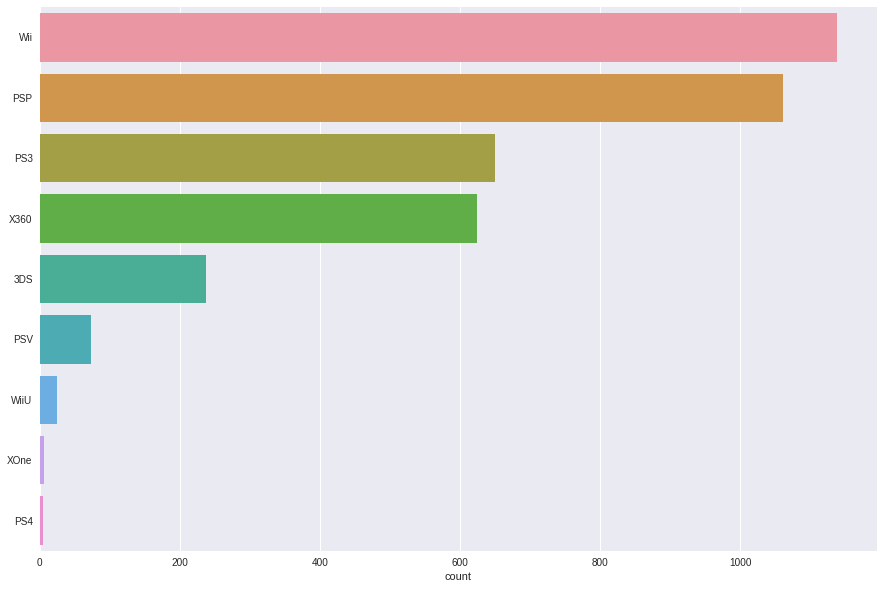

In [ ]:
plt.figure(figsize=(15, 10))
category_dict = dict(video_game[['platform']].groupby('platform')['platform'].count())

data_plot = dict(sorted(category_dict.items(), key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
sns.countplot(y=data_plot)
plt.show()

พบว่าข้อมูลที่ได้จาก Dataset ผู้พัฒนาเกมส่วนใหญ่ในช่วงตั้งแต่ปี 2004 ถึงปี 2020
จะพัฒนาให้กับ Platform เครื่อง Wii มากที่สุด

รองลงมาเป็น PSP, X360, PS3 ตามลำดับ และน้อยที่สุดคือ PS4

## แสดงข้อมูลจำนวนของประเภทเกมที่มีการผลิตออกมา

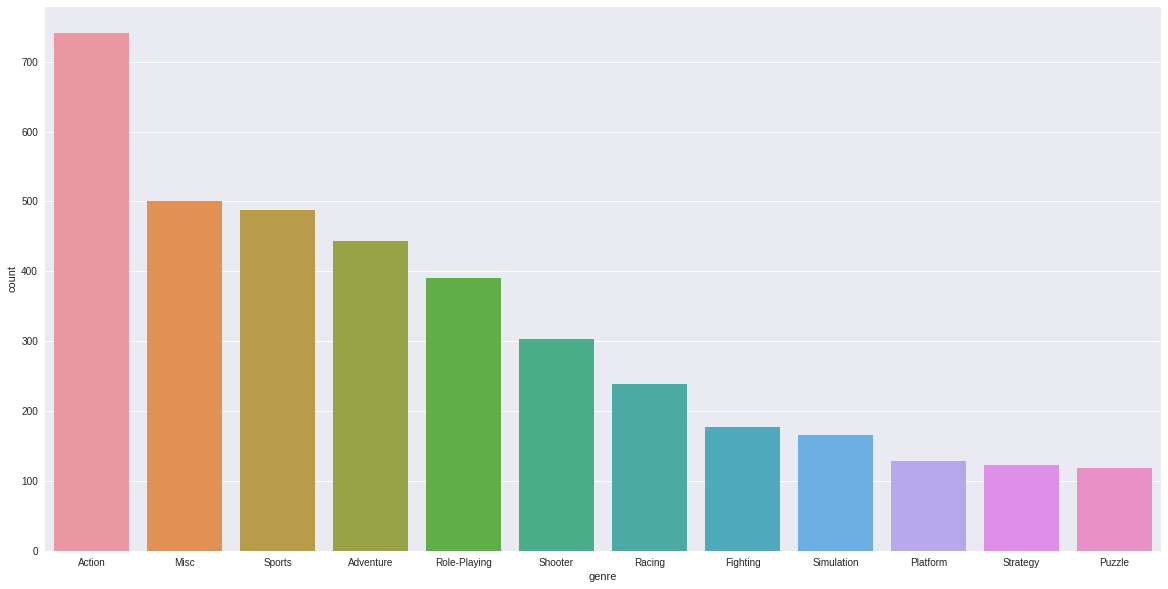

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(video_game.genre.dropna(), order = video_game.genre.value_counts().index);

พบว่า เกมประเภท Action มีการผลิตออกมาสูงที่สุด

ส่วนประเภทเกมที่มีการผลิตน้อยที่สุดคือ เกมประเภท Puzzle

## ประเภทเกมที่ได้รับความนิยมโดยสังเกตจากยอดขายจาก Global Sales

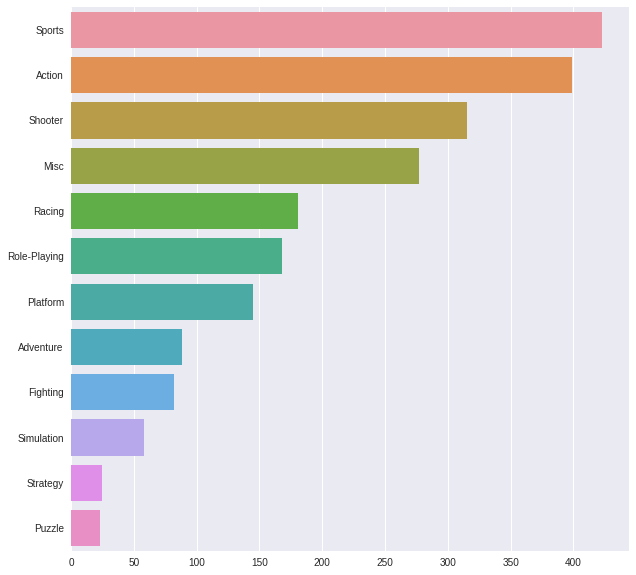

In [ ]:
plt.figure(figsize=(10, 10))
category_dict = dict(video_game[['global_sales', 'genre']].groupby(
    'genre')['global_sales'].sum())
data_plot = dict(sorted(category_dict.items(),
                 key=lambda kv: kv[1], reverse=True))
keys = list(data_plot.keys())
vals = [int(data_plot[k]) for k in keys]
sns.barplot(y=keys, x=vals)
plt.show()

จะสังเกตได้ว่า เกมที่ได้รับยอดขายจาก Global Sales มากที่สุดเป็นเกมประเภท Action และน้อยที่สุดคือเกมประเภท Puzzle

## เปรียบเทียบข้อมูลการผลิตเทียบกับข้อมูลการขาย

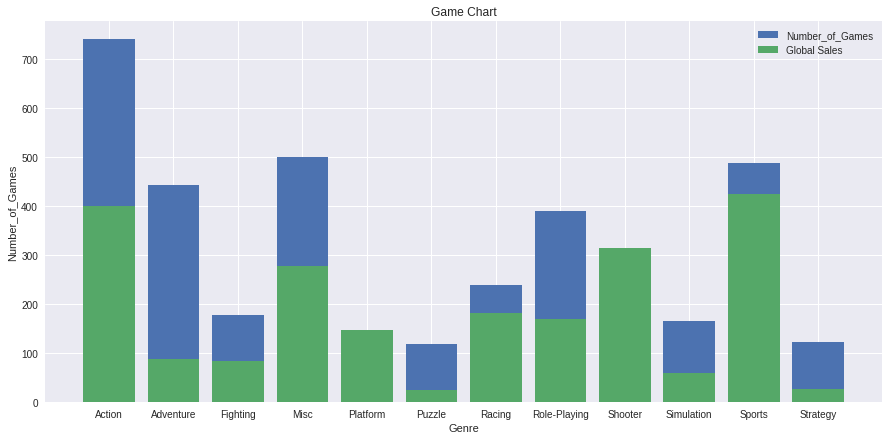

In [ ]:
years_df = video_game.groupby('genre')[['global_sales']].sum().join(
     video_game.groupby('genre')[['game_name']].count())
years_df.columns = ['Global_Sales', 'Number_of_Games']

plt.figure(figsize = (15,7))
y  = years_df.index
x1 = years_df['Global_Sales']
x2 = years_df['Number_of_Games']
# plt.plot(x, y1, label="Global Sales")
# plt.plot(x, y2, label="Number of games released")
# plt.plot()

# plt.xlabel("Genre")
# plt.title("Statistic for Video Games")
# plt.legend()
# plt.show()
plt.bar(y,x2, label="Number_of_Games")
plt.bar(y,x1, label="Global Sales")

plt.plot()

plt.xlabel("Genre")
plt.ylabel("Number_of_Games")
plt.title("Game Chart")
plt.legend()
plt.show()

## รายชื่อผู้พัฒนาเกมที่สร้างเกมมากที่สุด 20 อันดับ

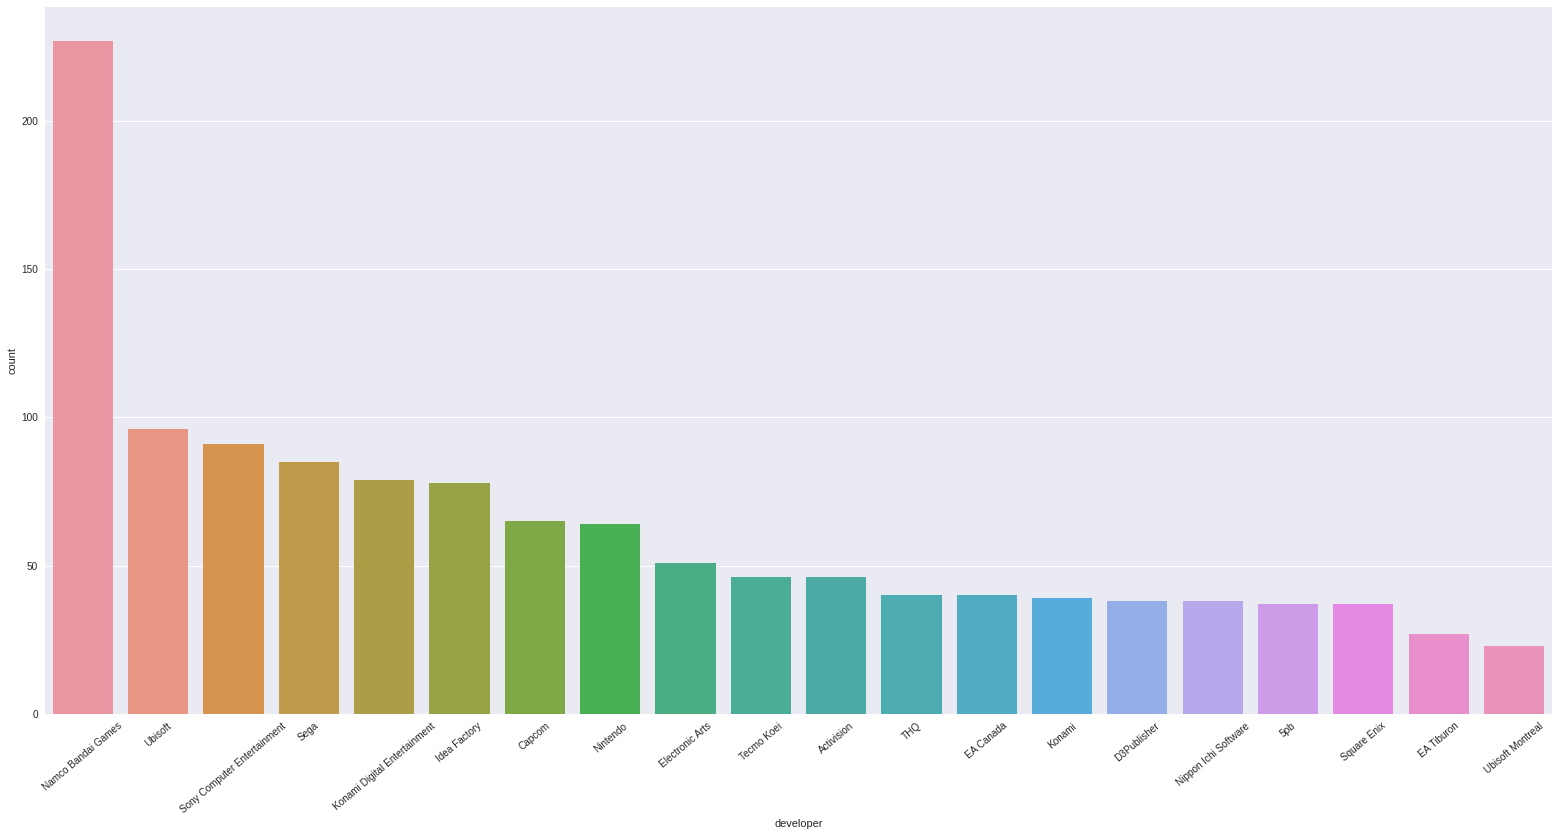

In [ ]:
plt.figure(figsize=(27, 13))
sns.countplot(video_game.developer.dropna(), order = video_game.developer.value_counts().iloc[:20].index)
plt.xticks(rotation=40);

พบว่า Namco Bandai Games ผลิตเกมออกมามากที่สุด

## Top 10 เกมที่มียอดขายสูงที่สุดใน Global Sales

Text(0, 0.5, 'Global Sales')

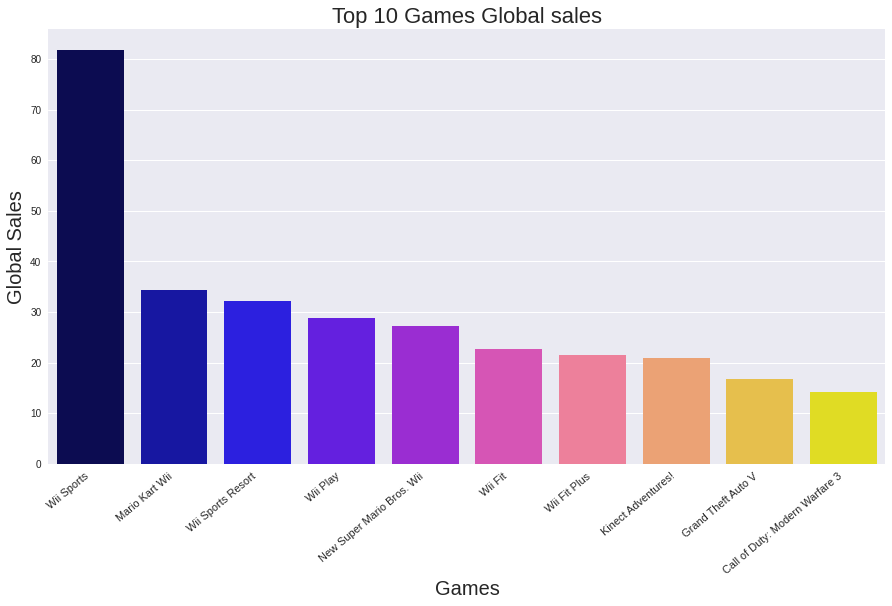

In [ ]:
top10=video_game[['game_name', 'global_sales']].sort_values(by = 'global_sales',ascending = False).head(10)
plt.figure(figsize=(15,8))
ax=sns.barplot(x="game_name", y="global_sales", data=top10, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Games Global sales',fontsize = 22)
ax.set_xlabel('Games',fontsize = 20) 
ax.set_ylabel('Global Sales', fontsize = 20)

พบว่าเกมที่มียอดขายสูงที่สุด คือ Wii Sports

รองลงมาคือ Mario Kart Wii และ Wii Sports Resort ตามลำดับ

# **Feature Engineering**

เนื่องจากสิ่งที่ต้องการจะทำคือ Game Recommendation

โดยการใช้ algorithm ที่เป็น TfidfVectorizer และ CountVectorizer เพื่อใช้ในการแบ่งคำภาษาอังกฤษ

In [ ]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
count_vectorizer = CountVectorizer(lowercase=True, stop_words='english')

สร้างข้อมูลที่จะใช้แนะนำชื่อเกมที่มีความใกล้เคียงกัน

In [ ]:
mix_data = video_game['game_name'] + "|" + video_game['platform'] + "|" + video_game['genre'] + "|" + video_game['publisher'] + "|" + video_game['developer']
mix_data.sample(5)

3042    NewU Fitness First Mind Body, Yoga & Pilates W...
4028    Basketball Hall of Fame Ultimate Hoops Challen...
4524    Gekiatsu!! Pachi Game Tamashi: CR Evangelion -...
4115    Minna no Sukkiri|PSP|Sports|Sony Computer Ente...
3411                      Truth or Lies|X360|Misc|THQ|THQ
dtype: object

สร้างตัว Matrix เพื่อหาข้อมูลของเกมที่มีความคล้ายคลึงกัน
 (Tfidf Vectorizer + Cosine Similarity)

In [ ]:
time_start = time.time()

cosine_similarity
game_matrix = tfidf_vectorizer.fit_transform(mix_data)
game_cosine_sim = cosine_similarity(game_matrix, game_matrix)

game_matrix.shape
time_end = time.time()

print(f"Game Similarity : {round(time_end - time_start, 5)} second")

Game Similarity : 0.26653 second


สร้างคลาสที่แนะนำข้อมูลขึ้นมา

In [ ]:
class Recommendations:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = video_game['game_name'][video_game['game_name'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = video_game['game_name'][video_game['game_name'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = video_game.reset_index()
        indices = pd.Series(metadata.index, index=metadata['game_name'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=game_cosine_sim):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = video_game[['game_name', 'platform', 'genre', 'publisher', 'developer']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.game_name != self.name]
        return recs.loc[recs.match_score > 0, ['game_name', 'platform', 'genre', 'publisher', 'developer','match_score']]

    def get_detail(self):
        return video_game.loc[video_game['game_name'] == self.name, ['game_name', 'platform', 'genre', 'publisher', 'developer']]

ลองค้นหาข้อมูลของเกมที่มีชื่อใกล้เคียงกัน

In [ ]:
recommend = Recommendations('monster')
recommend.get_detail()

,game_name,platform,genre,publisher,developer
64,Monster Hunter Freedom Unite,PSP,Role-Playing,Capcom,Capcom


ลองค้นหาข้อมูลที่มีข้อมูลใกล้เคียงกับที่ค้นหามากที่สุด

In [ ]:
time_start = time.time()

recommendation = recommend.get_recommendations()

time_end = time.time()
print(f"Content Recommendation : {round(time_end - time_start, 4)} s")

Content Recommendation : 0.011 s


In [ ]:
recommendation

,game_name,platform,genre,publisher,developer,match_score
81,Monster Hunter Freedom 3,PSP,Role-Playing,Capcom,Capcom,0.8846
191,Monster Hunter Freedom 2,PSP,Role-Playing,Capcom,Capcom,0.8846
440,Monster Hunter Freedom,PSP,Role-Playing,Capcom,Capcom,0.8846
2139,Monster Hunter G,Wii,Role-Playing,Capcom,Capcom,0.7585
3069,Monster Hunter Frontier Online,X360,Role-Playing,Capcom,Capcom,0.6330
4485,Monster Hunter Frontier Online: Season 9.0,X360,Role-Playing,Capcom,Capcom,0.5810
4696,Monster Hunter Frontier Online: Forward 1,X360,Role-Playing,Capcom,Capcom,0.5662
4734,Monster Hunter Frontier Online: Forward 2,X360,Role-Playing,Capcom,Capcom,0.5662
4641,Monster Hunter Frontier Online: Season 10,X360,Role-Playing,Capcom,Capcom,0.5502
1287,Monster Hunter Portable 3rd HD Ver.,PS3,Role-Playing,Capcom,Capcom,0.5402


# Modelling

## Benchmark 

สร้างตัว Matrix เพื่อหาข้อมูลของเกมที่มีความคล้ายคลึงกัน
 (Count Vectorizer + Linear Kernel)

In [ ]:
linear_kernel
game_matrix = count_vectorizer.fit_transform(mix_data)
game_lin_co = linear_kernel(game_matrix, game_matrix)

In [ ]:
class Recommendations_lin_co:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = video_game['game_name'][video_game['game_name'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = video_game['game_name'][video_game['game_name'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = video_game.reset_index()
        indices = pd.Series(metadata.index, index=metadata['game_name'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=game_lin_co):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = video_game[['game_name', 'platform', 'genre', 'publisher', 'developer']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.game_name != self.name]
        return recs.loc[recs.match_score > 0, ['game_name', 'platform', 'genre', 'publisher', 'developer','match_score']]

    def get_detail(self):
        return video_game.loc[video_game['game_name'] == self.name, ['game_name', 'platform', 'genre', 'publisher', 'developer']]

สร้างตัว Matrix เพื่อหาข้อมูลของเกมที่มีความคล้ายคลึงกัน
 (Tfidf Vectorizer + Linear Kernel)

In [ ]:
linear_kernel
game_matrix = tfidf_vectorizer.fit_transform(mix_data)
game_linear_tfidf = linear_kernel(game_matrix, game_matrix)

In [ ]:
class Recommendations_tfidf_lin:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = video_game['game_name'][video_game['game_name'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = video_game['game_name'][video_game['game_name'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = video_game.reset_index()
        indices = pd.Series(metadata.index, index=metadata['game_name'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=game_linear_tfidf):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = video_game[['game_name', 'platform', 'genre', 'publisher', 'developer']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.game_name != self.name]
        return recs.loc[recs.match_score > 0, ['game_name', 'platform', 'genre', 'publisher', 'developer','match_score']]

    def get_detail(self):
        return video_game.loc[video_game['game_name'] == self.name, ['game_name', 'platform', 'genre', 'publisher', 'developer']]

สร้างตัว Matrix เพื่อหาข้อมูลของเกมที่มีความคล้ายคลึงกัน
 (Count Vectorizer + Cosine Similarity)

In [ ]:
cosine_similarity
game_matrix = count_vectorizer.fit_transform(mix_data)
game_cosine_co = cosine_similarity(game_matrix, game_matrix)

In [ ]:
class Recommendations_count_cos:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = video_game['game_name'][video_game['game_name'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = video_game['game_name'][video_game['game_name'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = video_game.reset_index()
        indices = pd.Series(metadata.index, index=metadata['game_name'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=game_cosine_co):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = video_game[['game_name', 'platform', 'genre', 'publisher', 'developer']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.game_name != self.name]
        return recs.loc[recs.match_score > 0, ['game_name', 'platform', 'genre', 'publisher', 'developer','match_score']]

    def get_detail(self):
        return video_game.loc[video_game['game_name'] == self.name, ['game_name', 'platform', 'genre', 'publisher', 'developer']]

สร้างตัว Matrix เพื่อหาข้อมูลของเกมที่มีความคล้ายคลึงกัน
 (Tfidf Vectorizer + Cosine Similarity)

In [ ]:
cosine_similarity
game_matrix = tfidf_vectorizer.fit_transform(mix_data)
game_cosine_tfidf = cosine_similarity(game_matrix, game_matrix)

In [ ]:
class Recommendations_tfidf_cos:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = video_game['game_name'][video_game['game_name'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = video_game['game_name'][video_game['game_name'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = video_game.reset_index()
        indices = pd.Series(metadata.index, index=metadata['game_name'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=game_cosine_tfidf):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = video_game[['game_name', 'platform', 'genre', 'publisher', 'developer']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.game_name != self.name]
        return recs.loc[recs.match_score > 0, ['game_name', 'platform', 'genre', 'publisher', 'developer','match_score']]

    def get_detail(self):
        return video_game.loc[video_game['game_name'] == self.name, ['game_name', 'platform', 'genre', 'publisher', 'developer']]

## Benchmark Game Recommend

ทำการทดสอบการเปรียบเทียบข้อมูลซึ่งจะเปรียบเทียบด้วย

1. TfidfVectorizer กับ Cosine Similarity
2. CountVectorizer กับ Cosine Similarity
3. TfidfVectorizer กับ Linear Kernel
4. CountVectorizer กับ Linear Kernel

### Cosine Similarity

TfidfVectorizer



In [ ]:
recommend = Recommendations_tfidf_cos('monster')
time_start = time.time()
recommendation = recommend.get_recommendations()
time_end = time.time()
print(f"Content Recommendation : {round(time_end - time_start, 4)} s")
time1 = (f"{round(time_end - time_start, 4)} s")

Content Recommendation : 0.0134 s


In [ ]:
print('Using Tfidf + Cosine\n')
recommendation

Using Tfidf + Cosine



,game_name,platform,genre,publisher,developer,match_score
81,Monster Hunter Freedom 3,PSP,Role-Playing,Capcom,Capcom,0.8846
191,Monster Hunter Freedom 2,PSP,Role-Playing,Capcom,Capcom,0.8846
440,Monster Hunter Freedom,PSP,Role-Playing,Capcom,Capcom,0.8846
2139,Monster Hunter G,Wii,Role-Playing,Capcom,Capcom,0.7585
3069,Monster Hunter Frontier Online,X360,Role-Playing,Capcom,Capcom,0.6330
4485,Monster Hunter Frontier Online: Season 9.0,X360,Role-Playing,Capcom,Capcom,0.5810
4696,Monster Hunter Frontier Online: Forward 1,X360,Role-Playing,Capcom,Capcom,0.5662
4734,Monster Hunter Frontier Online: Forward 2,X360,Role-Playing,Capcom,Capcom,0.5662
4641,Monster Hunter Frontier Online: Season 10,X360,Role-Playing,Capcom,Capcom,0.5502
1287,Monster Hunter Portable 3rd HD Ver.,PS3,Role-Playing,Capcom,Capcom,0.5402


CountVectorizer

In [ ]:
recommend = Recommendations_count_cos('monster')
time_start = time.time()
recommendation = recommend.get_recommendations()
time_end = time.time()
print(f"Game Recommendation : {round(time_end - time_start, 4)} s")
time2 = (f"{round(time_end - time_start, 4)} s")

Game Recommendation : 0.0097 s


In [ ]:
print('Using Count + Cosine\n')
recommendation

Using Count + Cosine



,game_name,platform,genre,publisher,developer,match_score
81,Monster Hunter Freedom 3,PSP,Role-Playing,Capcom,Capcom,0.9535
191,Monster Hunter Freedom 2,PSP,Role-Playing,Capcom,Capcom,0.9535
440,Monster Hunter Freedom,PSP,Role-Playing,Capcom,Capcom,0.9535
2139,Monster Hunter G,Wii,Role-Playing,Capcom,Capcom,0.8040
3098,Last Ranker,PSP,Role-Playing,Capcom,Capcom,0.7462
3069,Monster Hunter Frontier Online,X360,Role-Playing,Capcom,Capcom,0.7273
4790,Breath of Fire III,PSP,Role-Playing,Capcom,Capcom,0.7035
4485,Monster Hunter Frontier Online: Season 9.0,X360,Role-Playing,Capcom,Capcom,0.6963
4696,Monster Hunter Frontier Online: Forward 1,X360,Role-Playing,Capcom,Capcom,0.6963
4734,Monster Hunter Frontier Online: Forward 2,X360,Role-Playing,Capcom,Capcom,0.6963


เมื่อเปรียบเทียบการ Benchmark ของ Cosine Similarity เลือกใช้ TfidfVectorizer เร็วกว่า แต่ผลลัพธ์คงเดิม

### Linear Kernel

TfidfVectorizer

In [ ]:
recommend = Recommendations_tfidf_lin('monster')
time_start = time.time()
recommendation = recommend.get_recommendations()
time_end = time.time()
print(f"Game Recommendation : {round(time_end - time_start, 4)} s")
time3 = (f"{round(time_end - time_start, 4)} s")

Game Recommendation : 0.0083 s


In [ ]:
print('Using Tfidf + Linear\n')
recommendation

Using Tfidf + Linear



,game_name,platform,genre,publisher,developer,match_score
81,Monster Hunter Freedom 3,PSP,Role-Playing,Capcom,Capcom,0.8846
191,Monster Hunter Freedom 2,PSP,Role-Playing,Capcom,Capcom,0.8846
440,Monster Hunter Freedom,PSP,Role-Playing,Capcom,Capcom,0.8846
2139,Monster Hunter G,Wii,Role-Playing,Capcom,Capcom,0.7585
3069,Monster Hunter Frontier Online,X360,Role-Playing,Capcom,Capcom,0.6330
4485,Monster Hunter Frontier Online: Season 9.0,X360,Role-Playing,Capcom,Capcom,0.5810
4696,Monster Hunter Frontier Online: Forward 1,X360,Role-Playing,Capcom,Capcom,0.5662
4734,Monster Hunter Frontier Online: Forward 2,X360,Role-Playing,Capcom,Capcom,0.5662
4641,Monster Hunter Frontier Online: Season 10,X360,Role-Playing,Capcom,Capcom,0.5502
1287,Monster Hunter Portable 3rd HD Ver.,PS3,Role-Playing,Capcom,Capcom,0.5402


CountVectorizer

In [ ]:
recommend = Recommendations_lin_co('monster')
time_start = time.time()
recommendation = recommend.get_recommendations()
time_end = time.time()
print(f"Game Recommendation : {round(time_end - time_start, 4)} s")
time4 = (f"{round(time_end - time_start, 4)} s")

Game Recommendation : 0.0087 s


In [ ]:
print('Using Count + Linear\n')
recommendation

Using Count + Linear



,game_name,platform,genre,publisher,developer,match_score
81,Monster Hunter Freedom 3,PSP,Role-Playing,Capcom,Capcom,10.0
191,Monster Hunter Freedom 2,PSP,Role-Playing,Capcom,Capcom,10.0
440,Monster Hunter Freedom,PSP,Role-Playing,Capcom,Capcom,10.0
1287,Monster Hunter Portable 3rd HD Ver.,PS3,Role-Playing,Capcom,Capcom,8.0
2139,Monster Hunter G,Wii,Role-Playing,Capcom,Capcom,8.0
3069,Monster Hunter Frontier Online,X360,Role-Playing,Capcom,Capcom,8.0
4485,Monster Hunter Frontier Online: Season 9.0,X360,Role-Playing,Capcom,Capcom,8.0
4641,Monster Hunter Frontier Online: Season 10,X360,Role-Playing,Capcom,Capcom,8.0
4696,Monster Hunter Frontier Online: Forward 1,X360,Role-Playing,Capcom,Capcom,8.0
4734,Monster Hunter Frontier Online: Forward 2,X360,Role-Playing,Capcom,Capcom,8.0


In [ ]:
print('TfidfVectorizer กับ Cosine Similarity = ' + time1)
print('CountVectorizer กับ Cosine Similarity = ' + time2)
print('TfidfVectorizer กับ Linear Kernel = ' + time3)
print('CountVectorizer กับ Linear Kernel = ' + time4)

TfidfVectorizer กับ Cosine Similarity = 0.0134 s
CountVectorizer กับ Cosine Similarity = 0.0097 s
TfidfVectorizer กับ Linear Kernel = 0.0083 s
CountVectorizer กับ Linear Kernel = 0.0087 s


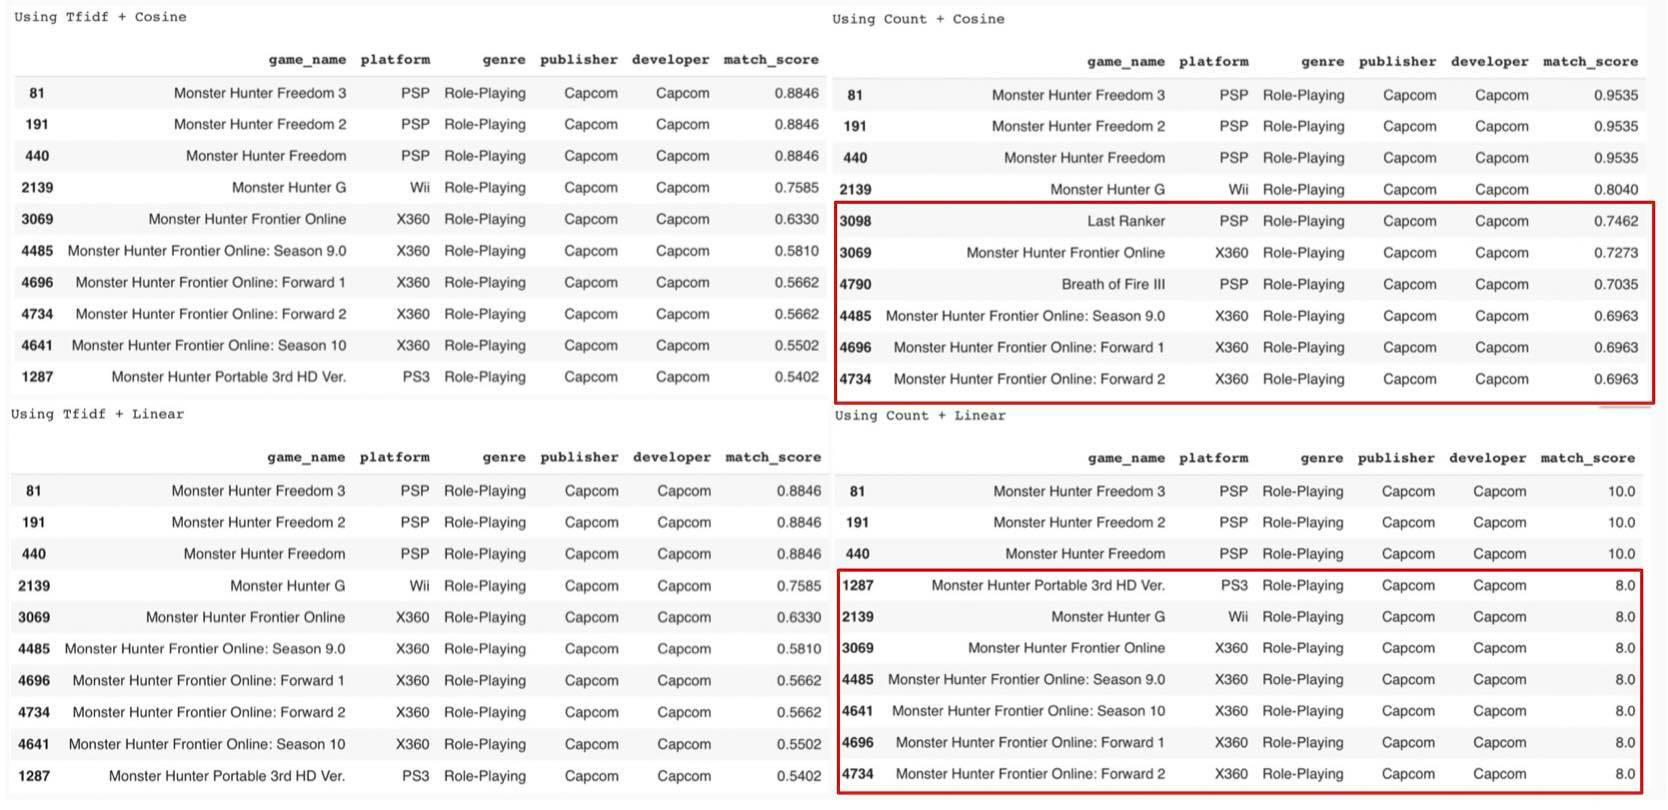

เมื่อเปรียบเทียบการ Benchmark 

TfidfVectorizer กับ Linear Kernel มีความเร็วกว่าจึงเลือกใช้ตัวนี้

# Pipeline

## Preprocessing

- แก้ไขช่อง publisher, developer, rating ที่เสียหาย
- แก้ไขชื่อ Column ให้ง่ายต่อการนำไปใช้งาน
- Drop Row ที่เป็นค่า Null
- Drop Row ที่มีค่าซ้ำ

In [ ]:
class PipeLine():

    def data_cleaning(self, data):
        data = data.reindex(columns=["name", "platform", "release year", "genre", "global sales", "publisher", "developer", "rating"])
        data.rename(columns={'name': 'game_name', 'release year': 'year_of_release', 'global sales': 'global_sales'}, inplace=True)
        data.at[1355, "publisher"] = "Sega"
        data.at[1713, "publisher"] = "Bandai Namco"
        data.at[3131, "publisher"] = "Banpresto"
        data.at[4067, "publisher"] = "Nippon Ichi Software"
        data.at[4522, "publisher"] = "Capcom"
        data.at[4761, "publisher"] = "Alchemist"
        data.at[5131, "publisher"] = "Namco Bandai Games"
        data.at[5267, "publisher"] = "Nintendo"
        data.at[5294, "publisher"] = "G.rev"
        data.at[5296, "publisher"] = "Acquire"
        data["developer"].fillna(data["publisher"], inplace=True)
        data['publisher'] = np.where(data['publisher'] =='Unknown', data['developer'], data['publisher'])
        data["rating"].fillna('RP', inplace=True)
        data.dropna(axis=0, inplace=True)
        data['year_of_release'] = data['year_of_release'].astype(int)
        data.drop_duplicates(subset='game_name', inplace=True)
        return data
    
    def tfidf_fit_transform(self,data):
        tfidf_fit_transform = TfidfVectorizer(lowercase=True, stop_words = 'english')
        tfidf_fit_matrix = tfidf_fit_transform.fit_transform(data['game_name'] + "|" + data['platform'] + "|" + data['genre'] + "|" + data['publisher'] + "|" + data['developer'])
        return tfidf_fit_matrix
    
    def execution(self, data):
      df = data.copy()
      df = self.data_cleaning(df)
      return self.tfidf_fit_transform(df)

## Analytical

In [ ]:
pipeline = PipeLine()

In [ ]:
game_matrix = pipeline.execution(video_game_data)
game_matrix

<3817x4978 sparse matrix of type '<class 'numpy.float64'>'
	with 31171 stored elements in Compressed Sparse Row format>

In [ ]:
game_cosine_Tfidf = linear_kernel(game_matrix, game_matrix)
game_cosine_Tfidf

array([[1.        , 0.59264868, 0.84943395, ..., 0.        , 0.        ,
        0.04647118],
       [0.59264868, 1.        , 0.50341591, ..., 0.        , 0.        ,
        0.03821471],
       [0.84943395, 0.50341591, 1.        , ..., 0.        , 0.        ,
        0.0394742 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.02136886],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04647118, 0.03821471, 0.0394742 , ..., 0.02136886, 0.        ,
        1.        ]])

## Modelling

In [ ]:
class Recommendations:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = video_game['game_name'][video_game['game_name'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = video_game['game_name'][video_game['game_name'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = video_game.reset_index()
        indices = pd.Series(metadata.index, index=metadata['game_name'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=game_cosine_Tfidf):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = video_game[['game_name', 'platform', 'genre', 'publisher', 'developer']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.game_name != self.name]
        return recs.loc[recs.match_score > 0, ['game_name', 'platform', 'genre', 'publisher', 'developer', 'match_score']]

    def get_detail(self):
        return video_game.loc[video_game['game_name'] == self.name, ['game_name', 'platform', 'genre', 'publisher', 'developer']]

In [ ]:
def prepare_recommed(name):
    return print('pass'), Recommendations(name).get_recommendations()


# Deployment

In [ ]:
iface = gr.Interface(prepare_recommed,inputs=[gr.inputs.Textbox(label='Game Recommendation', 
                default="monster")],outputs=[gr.outputs.Dataframe(label='monster'),gr.outputs.Dataframe(label='Game Recommendation')])
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://44796.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://44796.gradio.app')

# References



*   **Video games - Predicting global sales**
[https://www.kaggle.com/maxkliment/video-games-predicting-global-sales/notebook](https://)
*   **MetaCritic Scraper** [https://github.com/wtamu-cisresearch/scraper](https://)
*   **Charts in Colaboratory** [https://colab.research.google.com/notebooks/charts.ipynb](https://)
*   **Exploring the Dataset, Bivariate Analysis** [https://www.kaggle.com/etakla/exploring-the-dataset-bivariate-analysis#Publishers](https://)
*   **Book Recommender: Collaborative Filtering, Shiny** [https://www.kaggle.com/philippsp/book-recommender-collaborative-filtering-shiny](https://)
*   **Netflix - Movie recommendation** [https://www.kaggle.com/laowingkin/netflix-movie-recommendation](https://)

# Members


*   1620707826 นางสาวรัชชประภา นรินทร์ (มะนาว) - **Design**
*   1620707958 นางสาวอาชัญญา เวป (แจนนี่) - **Visualizer**
*   1620708022 นายรดิศ สวรรคทัต (สายฟ้า) - **Developer**